# Cab-Driver Agent

    The goal is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process. 
    
steps followed:

    1. Creating environment
    2. Defining epsilon-greedy strategy
    3. Creating DQN architecture1 for agent 
    4. Tracking state-action pairs and reward of episodes for convergence


In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import pylab
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt


In [2]:
# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix.shape

(5, 5, 24, 7)

#### Tracking the state-action pairs for checking convergence


In [4]:
def track_state(state):
    return ('-'.join(str(e) for e in state))

def track_action(action):
    return ('-'.join(str(e) for e in action))

In [5]:
# eg
state = (1,13,4)
track_state(state)

'1-13-4'

In [6]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_Qvalues = [('3-0-0', '3-1'),('3-0-0', '3-2'), ('3-0-0', '2-3'),('3-0-0', '3-4'),
                      ('3-0-0', '4-0'),('3-0-0', '4-1'),('3-0-0', '4-2'),('3-0-0', '4-3')]    
    for q_value in sample_Qvalues:
        state = q_value[0]
        action = q_value[1]
        States_track[state][action] = []
       

In [7]:
# save Q-vqlue for tracking state 
#curr_state = '3-0-4'
#curr_action = '2-1'
#q_action = '3-2'
def save_tracking_states(curr_state, curr_action, q_action):
    for state in States_track.keys():
        if state == curr_state:
            for action in States_track[state].keys():
                if action == curr_action:
                    States_track[state][action].append(q_action)

#save_tracking_states(curr_state, curr_action, q_action)                    for checking

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001   
        
        self.epsilon = 1.0  # will get updated for each episode
        self.epsilon_decay =  0.99     #-0.0005
        self.epsilon_min = 0.01
       # self.epsilon_max = 1.0
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
        
        # output neurons = number of possible actions    
        model.add(Dense(self.action_size, activation='relu',kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model
     
        
    def get_action(self, state ,index_pos_actions,time):
        """ Choose action according to ε-greedy policy. If the generated number is less than ε,
        we will explore, otherwise we will exploit the policy by choosing the
        action which has maximum Q-value.
        """
        #self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay*time)
        z = np.random.random()
        # choose random action if generated random number is less than ε.
        if z <= self.epsilon:
            new_action = random.choice(index_pos_actions)  # Exploration
        
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            # state into array format
            state = env.state_encod_arch1(state)
            state = np.reshape(state,[1,self.state_size])   # 5+24+7
            q_value = self.model.predict(state)
            # q-values of all possible actions
            possible_q_value = [q_value[0][i] for i in index_pos_actions]
            # returns index of maximum q-valued of action
            new_action = index_pos_actions[np.argmax(possible_q_value)]
        return new_action

    def append_sample(self, state, action, reward, next_state, done):
        # save sample <s,a,r,s'> to the replay memory
        # Adding sample to the memory. 
        self.memory.append((state, action, reward, next_state, done))   
     
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialize input and output batch
            update_input = np.zeros((self.batch_size,self.state_size))
            update_output = np.zeros((self.batch_size,self.state_size))
            actions, rewards,terminal = [], [],[]
            
            for i in range(self.batch_size):
                state, action, reward, next_state,done= mini_batch[i]
                actions.append(action)
                rewards.append(reward)
                terminal.append(done)
                
                # Update your 'update_output' and 'update_input' batch
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)

                 
            # Predict the target from earlier model
            target = self.model.predict(update_input)
            # target for the Q-network
            target_q_val = self.model.predict(update_output)
   
            # update the target values
            for i in range(self.batch_size):
                if terminal[i]:    # terminal state 
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * max(target_q_val[i])
           
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    #Defining a function to save the model weights as a pickle file        
    def save_obj(self, name ):
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(self.model.get_weights(), f, pickle.HIGHEST_PROTOCOL)
    
    

### DQN block

In [9]:

episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 5000   # 7000  #10000   #15000

m = 5
t = 24
d = 7
# Initialize - for tracking
States_track = collections.defaultdict(dict)
initialise_tracking_states() 

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()


# Set up state and action sizes.
state_size = m+t+d
action_size = len(env.action_space)

# agent class
agent = DQNAgent(state_size=state_size, action_size=action_size)

# to track rewards in each episode
rewards_per_episode = []

start_time = time.time()

for episode in range(n_episodes):
    done = False
    
    # after each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()

    # reset at the start of each episode
    total_time = 0  # Total time for an episode
    trip_time =0 # time taken for each state
    score = 0
    init_state = state  # for tracking
    
    while not done:
        # possible actions
        possible_actions_indices, actions = env.requests(state)
       
        # apply epsilon-greedy approach to get an action from possible actions 
        action = agent.get_action(state, possible_actions_indices,episode)
   
        # find reward 
        reward = env.reward_func(state, env.action_space[action], Time_matrix)

        #find next state
        next_state,trip_time = env.next_state_func(state, env.action_space[action], Time_matrix)
       
        # time taken by the cab from start of the episode 
        total_time += trip_time
        if (total_time > episode_time):
            # when the battery needs to be recharged
            done = True
            # append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            score += reward
   
        else:
            # append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # Train the model 
            #agent.train_model()
            score += reward
            state = next_state

          
    # decay in ε 
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay    

    # train the model
    if (episode + 1) %  20 == 0:  # check this 
        agent.train_model()
    
    # store the reward and the episode for tracking
    rewards_per_episode.append(score)
       
    # To track convergence
    # change initial state format -- (1,0,0) to 1-0-0
    save_track_state = track_state(init_state)
    # encode initial state and convert into array
    track_state_encode = env.state_encod_arch1(init_state)
    track_state_encode = np.reshape(track_state_encode, [1, state_size])

    # get Q-values from the model
    save_q_values = agent.model.predict(track_state_encode)[0]
   
    for index in range(len(env.action_space)):
        # changes each action -->(1,2) into 1-2  for tracking
        save_track_action = track_action(env.action_space[index])
        # to save tracked q-values of tracked states
        save_tracking_states(save_track_state, save_track_action, save_q_values[index])
    
    
    if (episode + 1) % 200 == 0:
        print("Episode:", episode, " Reward :", score, "memory length:", len(agent.memory), "epsilon:", agent.epsilon)
    
    if (episode + 1) % 500 == 0:
        # saves the model
        agent.save_obj("cardriver_DQN_arch1"+ str(score))
        #save_obj(agent.model,"cardriver_DQN_arch1" + str(score))    

# save the final model
agent.save_obj("cardriver_DQN_arch1_final"+ str(score))
elapsed_time = time.time() - start_time
print(elapsed_time)

Episode: 199  Reward : -221 memory length: 2000 epsilon: 0.13397967485796175
Episode: 399  Reward : 61 memory length: 2000 epsilon: 0.017950553275045134
Episode: 599  Reward : 179 memory length: 2000 epsilon: 0.009920974201040588
Episode: 799  Reward : 147 memory length: 2000 epsilon: 0.009920974201040588
Episode: 999  Reward : 307 memory length: 2000 epsilon: 0.009920974201040588
Episode: 1199  Reward : 87 memory length: 2000 epsilon: 0.009920974201040588
Episode: 1399  Reward : 436 memory length: 2000 epsilon: 0.009920974201040588
Episode: 1599  Reward : 31 memory length: 2000 epsilon: 0.009920974201040588
Episode: 1799  Reward : 350 memory length: 2000 epsilon: 0.009920974201040588
Episode: 1999  Reward : 625 memory length: 2000 epsilon: 0.009920974201040588
Episode: 2199  Reward : 407 memory length: 2000 epsilon: 0.009920974201040588
Episode: 2399  Reward : 274 memory length: 2000 epsilon: 0.009920974201040588
Episode: 2599  Reward : 798 memory length: 2000 epsilon: 0.0099209742010

### Tracking Convergence and Reward

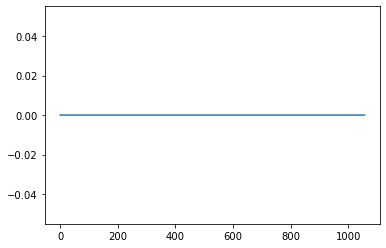

In [29]:
values = States_track['3-0-0']['4-3']
plt.plot(values)
#print(values)

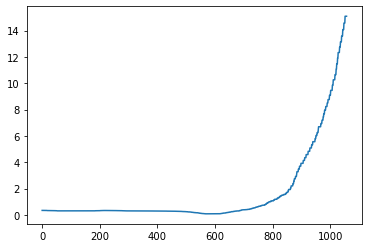

In [33]:
values = States_track['3-0-0']['3-4']
plt.plot(values)

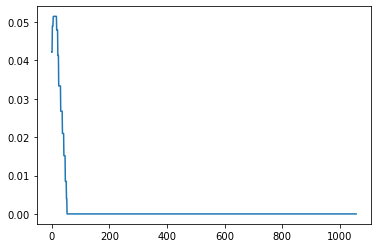

In [40]:
values = States_track['3-0-0']['4-1']
plt.plot(values)

In [ ]:
#States_track['3-0-0']['3-4']

In [19]:
print(len(rewards_per_episode))

5000


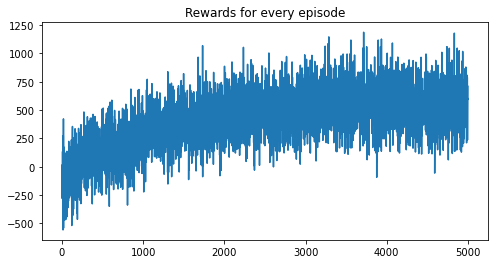

In [45]:
# plot rewards 

plt.figure(0, figsize=(8,4))
plt.title('Rewards for every episode')
xaxis = np.asarray(range(0, len(rewards_per_episode)))
plt.plot(xaxis,np.asarray(rewards_per_episode))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [23]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

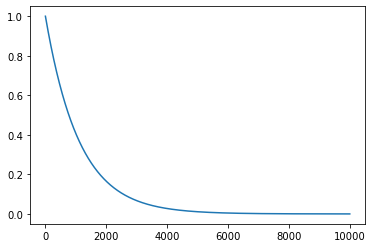

In [24]:
plt.plot(time, epsilon)
plt.show()